# Result Analysis
1. SCAN

In [115]:
import os
from collections import Counter

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [116]:
# I/O
RESULT = 'result'
LOG = 'log'
EXP1 = 'exp1'
EXP2 = 'exp2'
EXP3 = 'exp3'
EXP4 = 'exp4'

## Helper Function

In [117]:
def load_txt(path: str) -> list:
    with open(path, 'r', encoding='utf-8') as f:
        return f.read().splitlines()

In [118]:
data_src = 'scan_l12'
model_name = 'bi_lstm_rnn_att'
task = 10 # number of primitives
exp = EXP3

# Log

In [119]:
raw_result = load_txt(os.path.join(LOG, exp, data_src, str(task), model_name, 'test.txt'))

In [120]:
epochs, tk_acc, seq_acc = [], [], []
for r in raw_result:
    if 'Test Epoch' in r:
        r = r.split()
        epochs.append(r[2])
        tk_acc.append(r[-3].split(':')[-1])
        seq_acc.append(r[-1].split(':')[-1])

epochs = [int(e) for e in epochs]
tk_acc = [float(a) for a in tk_acc]
seq_acc = [float(a) for a in seq_acc]

In [121]:
tk_acc

[0.8938,
 0.9699,
 0.9805,
 0.9832,
 0.9865,
 0.9907,
 0.9922,
 0.9925,
 0.9937,
 0.9934]

In [122]:
print(seq_acc)

[0.3444, 0.8123, 0.8998, 0.9084, 0.9379, 0.9527, 0.9632, 0.9672, 0.9719, 0.9733]


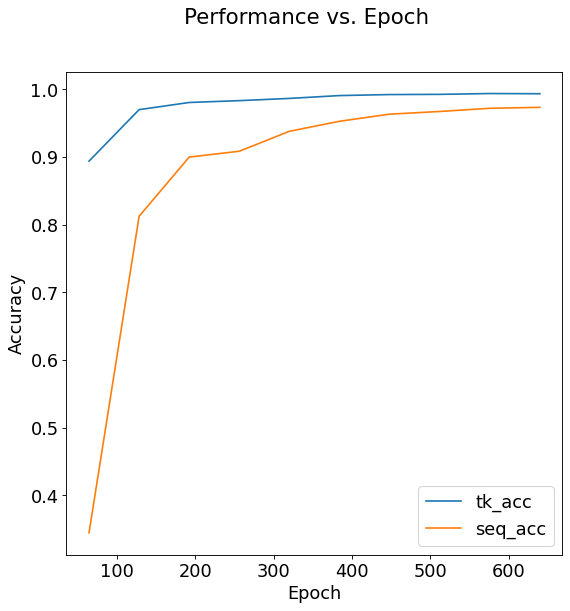

In [123]:
plt.subplots(figsize = (8, 8), dpi=80)
plt.plot(epochs, tk_acc, label='tk_acc')
plt.plot(epochs, seq_acc, label='seq_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.suptitle('Performance vs. Epoch')
plt.legend()
plt.show()

# Result

In [124]:
raw_result = load_txt(os.path.join(RESULT, exp, data_src, str(task), model_name, 'test.txt'))

In [125]:
raw_result[:10]

['Src: jump_0 opposite left thrice after jump_0 left twice',
 'Tgt: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP',
 'Pred: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP',
 'Src: jump_0 opposite left twice and jump_0 twice',
 'Tgt: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_JUMP I_JUMP',
 'Pred: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP',
 'Src: jump_0 around left twice after jump_0 around right twice',
 'Tgt: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP',
 'Pred: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I

In [126]:
xs, ys, ys_ = [], [], []
for r in raw_result:
#     if 'turn' not in r:
    if 'Src: ' in r:
        xs.append(r.split('Src: ')[-1])
    elif 'Tgt:' in r:
        ys.append(r.split('Tgt: ')[-1])
    elif 'Pred: ' in r:
        ys_.append(r.split('Pred: ')[-1])
    else:
        print(r)
#     else:
#         print(r)

In [127]:
# sequence accuracy
len([_ for y, y_ in zip(ys, ys_) if y == y_]) / len(xs)

0.9732675837010122

In [128]:
xs[0]

'jump_0 opposite left thrice after jump_0 left twice'

## Primitives

In [129]:
extra_primitive_xs = ['run', 'jump', 'look', 'walk']
extra_primitive_ys = ['I_RUN', 'I_JUMP', 'I_LOOK', 'I_WALK']
new_primitives = [p + '_{}'.format(i) for i in range(task) for p in extra_primitive_xs]

### Sequence Accuracy

In [130]:
# source vocab
c = Counter()
for x in xs:
    c.update(x.split())

all_dict = {p:c[p] for p in new_primitives}

In [131]:
# true vocab
c = Counter()
for x, y, y_ in zip(xs, ys, ys_):
    if y == y_:
        c.update(x.split())
        
true_dict = {p:c[p] for p in new_primitives}

In [132]:
# seq acc per primitive
primitive_seq_acc_dict = {p: true_dict[p]/all_dict[p] if all_dict[p] else 0 for p in new_primitives}

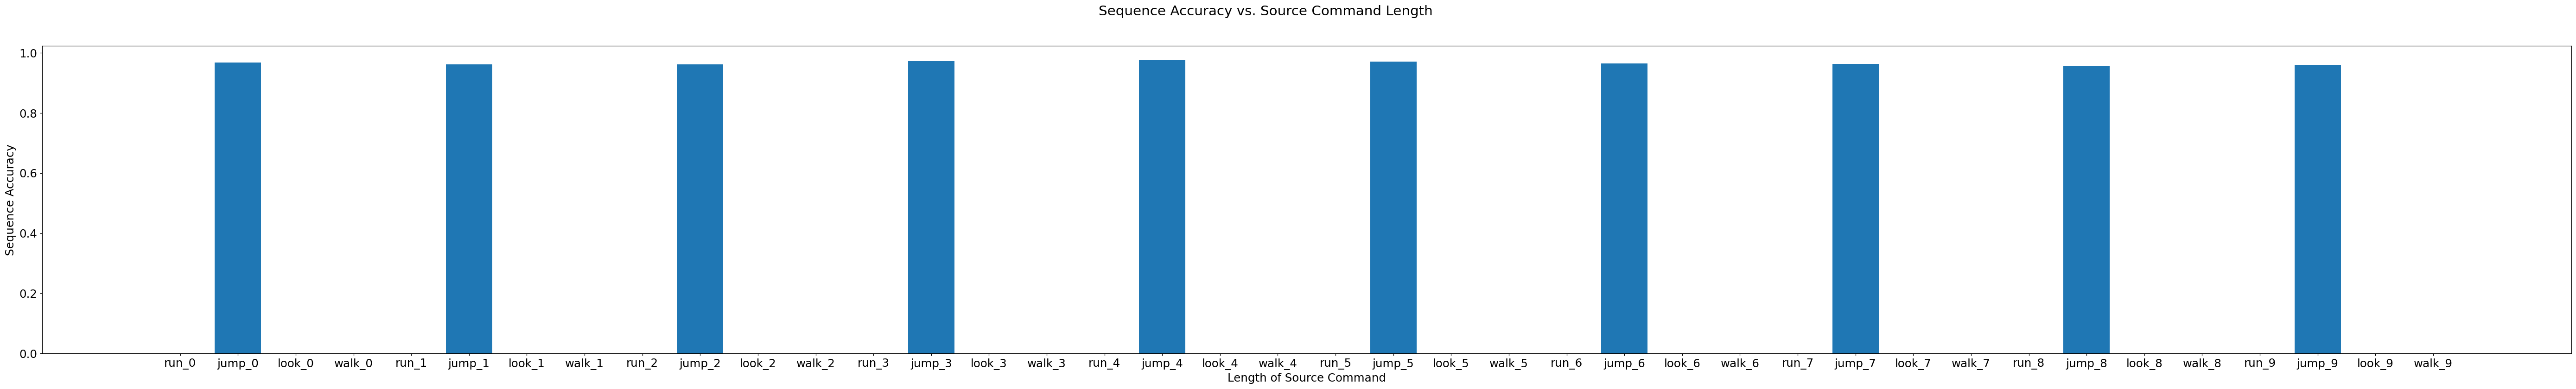

In [133]:
plt.subplots(figsize = (64, 8), dpi=110)
plt.bar(new_primitives, primitive_seq_acc_dict.values())
plt.xlabel('Length of Source Command')
plt.ylabel('Sequence Accuracy')
plt.suptitle('Sequence Accuracy vs. Source Command Length')
plt.show()

### Case Study - run

In [107]:
# for x, y, y_ in zip(xs, ys, ys_):
#     if 'run' in ''.join(x):
#         print(x)
#         print(y)
#         print(y_)

## Source Length

In [134]:
lens_list = []
for x, y, y_ in zip(xs, ys, ys_):
    if y == y_:
        lens_list.append(len(x.split()))

In [135]:
c = Counter()
c.update(lens_list)
true_dict = dict(c)

print(true_dict)

{8: 23031, 9: 11520, 7: 22090, 6: 12732, 3: 181, 5: 4440, 4: 967, 2: 39}


In [136]:
c = Counter()
c.update([len(x.split()) for x in xs])
all_dict = dict(c)

print(all_dict)

{8: 23040, 7: 22400, 9: 11520, 4: 1280, 6: 13440, 5: 5120, 3: 220, 2: 40}


In [137]:
acc_lens = [true_dict[k] / all_dict[k] for k in true_dict.keys()]
acc_lens

[0.999609375,
 1.0,
 0.9861607142857143,
 0.9473214285714285,
 0.8227272727272728,
 0.8671875,
 0.75546875,
 0.975]

In [138]:
for k, a in zip(true_dict.keys(), acc_lens):
    print(k, a)

8 0.999609375
9 1.0
7 0.9861607142857143
6 0.9473214285714285
3 0.8227272727272728
5 0.8671875
4 0.75546875
2 0.975


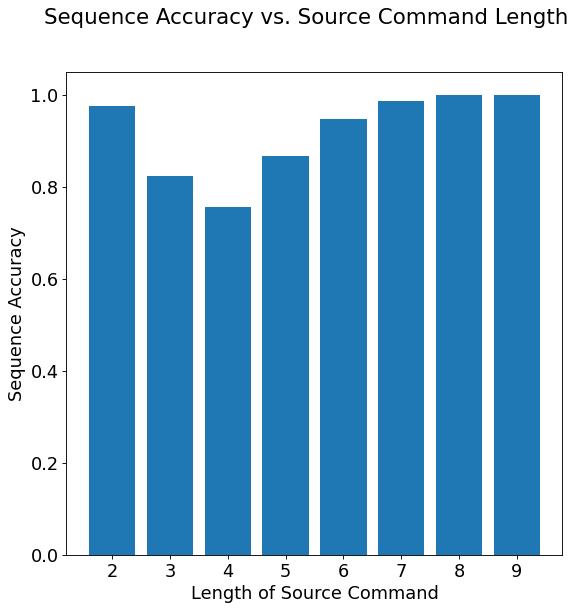

In [139]:
plt.subplots(figsize = (8, 8), dpi=80)
plt.bar(list(true_dict.keys()), acc_lens)
plt.xlabel('Length of Source Command')
plt.ylabel('Sequence Accuracy')
plt.suptitle('Sequence Accuracy vs. Source Command Length')
plt.show()

### Case Study - Length

In [140]:
for x, y, y_ in zip(xs, ys, ys_):
    if len(x.split()) == 2 and y != y_:
        print(x)
        print(y)
        print(y_)
        print()

jump_8 thrice
I_JUMP I_JUMP I_JUMP
I_TURN_LEFT I_JUMP I_JUMP

